In [33]:
#### In this notebook, we use antevents to read in some previously
# captured lux (light level) sensor data. We use a sliding window
# transducer to smooth the data and then convert both the raw data and
# the smoothed data to Pandas "Series" data values. These can then be
# plotted directly in jupyter.

# Some initial setup
import pandas as pd
# needed to get the graphs to show up
%matplotlib inline
import matplotlib.style
# To workaround a bug in pandas, see
# http://stackoverflow.com/questions/33995707/attributeerror-unknown-property-color-cycle
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

print("pandas version=%s"% pd.__version__)
print("matplotlib version=%s" % matplotlib.__version__)

pandas version=0.18.1
matplotlib version=1.5.1


In [34]:
# Make sure we can see the antevents package
import sys
import os.path
antpath=os.path.abspath('../../../antevents-python')
assert os.path.exists(antpath)
assert os.path.exists(os.path.join(antpath, 'antevents'))
if antpath not in sys.path:
    sys.path.append(antpath)
import antevents.base

In [35]:
# Some setup for our analysis
import asyncio
from pytz import timezone
from antevents.base import Filter,Publisher,Scheduler,SensorEvent,\
                           filtermethod
from antevents.adapters.csv import CsvReader
from antevents.adapters.pandas import PandasSeriesWriter
from antevents.linq.transducer import SensorSlidingMean
import antevents.linq.combinators
import antevents.linq.select

PDT=timezone('America/Los_Angeles')
scheduler = Scheduler(asyncio.get_event_loop())

In [36]:
# Now, read in the spreadsheet of lux values and build the
# dataflow to process the data
import math
from lux_analysis import SensorSlidingMeanPassNaNs, fill_in_missing_times, CaptureNaNIndexes

DIR = '../data_files/'
ROOM = 'front-room'
reader = CsvReader(DIR+ROOM+'.csv')


# The raw writer captures the raw spreadsheet data
raw_series_writer = PandasSeriesWriter(tz=PDT)
# The smoothed writer captures the data that was passed through a
# sliding average  transducer. We average over the last 5 samples.
smoothed_series_writer = PandasSeriesWriter(tz=PDT)

# We build and maintain a list of the NaN indexes, so that we can
# update them at will. This is needed because the clustering algorithm
# doesn't handle them
capture_nan_indexes = CaptureNaNIndexes()

# The smoothed data coming out of the sliding window mean is floating
# point. We round everything to the nearest integer, since that the
# accuracy we started with.
def round_event_val(x):
    if not math.isnan(x.val):
        return SensorEvent(ts=x.ts, sensor_id=x.sensor_id,
                           val=int(round(x.val)))
    else:
        return x

# Now we can put all the processing steps together
reader.fill_in_missing_times()\
      .passthrough(raw_series_writer)\
      .transduce(SensorSlidingMeanPassNaNs(5)).select(round_event_val).passthrough(smoothed_series_writer)\
      .passthrough(capture_nan_indexes).output_count()
reader.print_downstream()
    
# run it!
scheduler.schedule_recurring(reader)
scheduler.run_forever()
print("Ran the stream")


***** Dump of all paths from CsvReader(../data_files/front-room.csv) *****
  CsvReader(../data_files/front-room.csv) => fill_in_missing_times() => <antevents.adapters.pandas.PandasSeriesWriter object at 0x11e7522e8>
  CsvReader(../data_files/front-room.csv) => fill_in_missing_times() => transduce(SensorSlidingMean(5)) => select => <antevents.adapters.pandas.PandasSeriesWriter object at 0x11e794198>
  CsvReader(../data_files/front-room.csv) => fill_in_missing_times() => transduce(SensorSlidingMean(5)) => select => <lux_analysis.CaptureNaNIndexes object at 0x114979908>
  CsvReader(../data_files/front-room.csv) => fill_in_missing_times() => transduce(SensorSlidingMean(5)) => select => output_count
***************************************************
Found 3 missing samples
Found 15 missing samples
Found 82 missing samples
Found 190 missing samples
Found 22005 missing samples
Found 5 missing samples
************************************
*      15293 events processed      *
******************

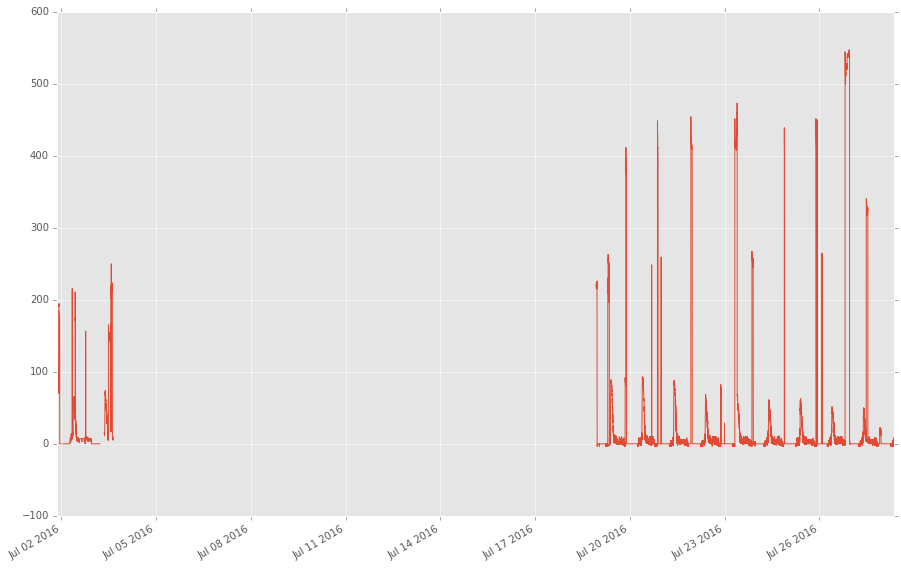

In [37]:
# graph the full raw series
raw_series_writer.result.plot(figsize=(15,10))

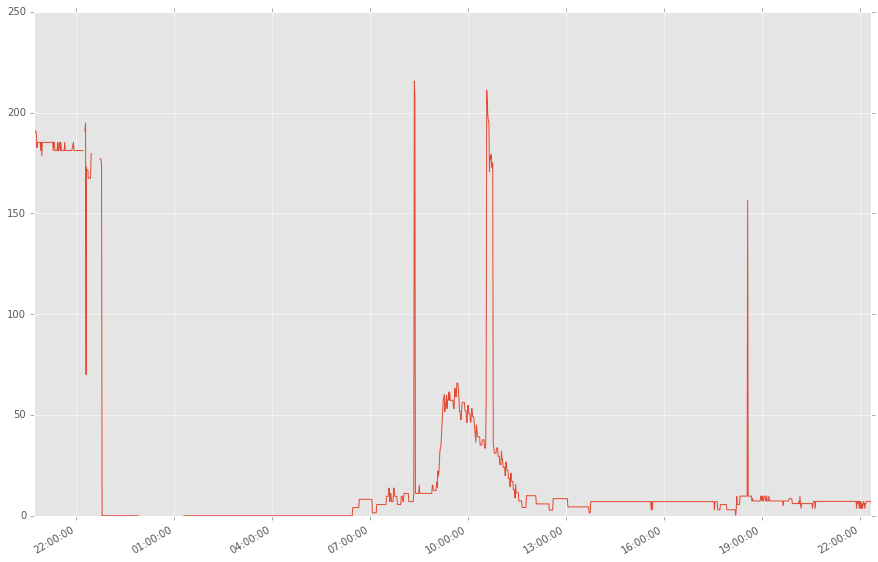

In [38]:
# Graph the last day of the raw data
raw_series_writer.result[:1440].plot(figsize=(15,10))

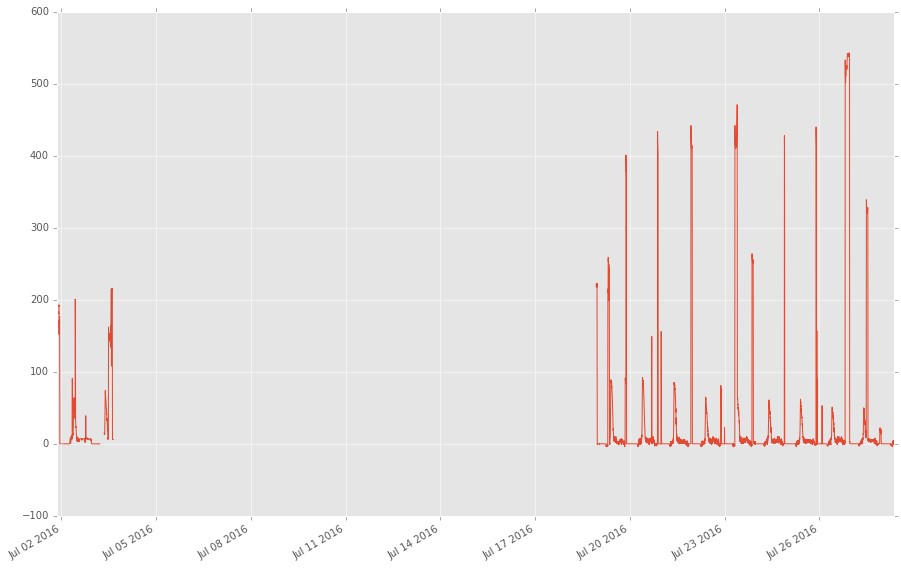

In [39]:
# graph the smoothed series
smoothed_series_writer.result.plot(figsize=(15,10))

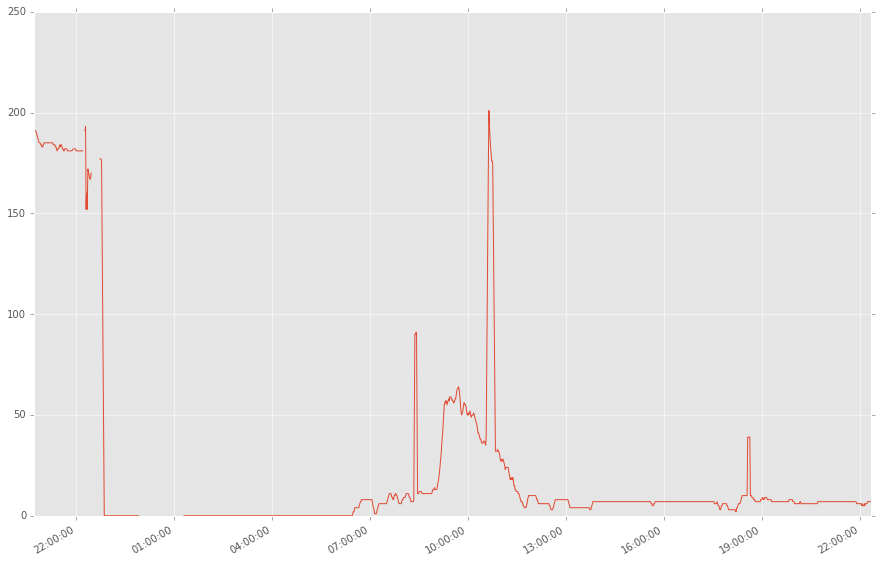

In [40]:
# Graph the last day of the smoothed data
smoothed_series_writer.result[:1440].plot(figsize=(15,10))

replacing index 90 with 0.0
replacing index 106 with 0.0
replacing index 179 with 0.0
replacing index 1859 with 0.0
replacing index 2285 with 0.0
replacing index 7146 with 0.0
kmeans labels: [2 2 2 ..., 0 0 0]


(0, 3.5)

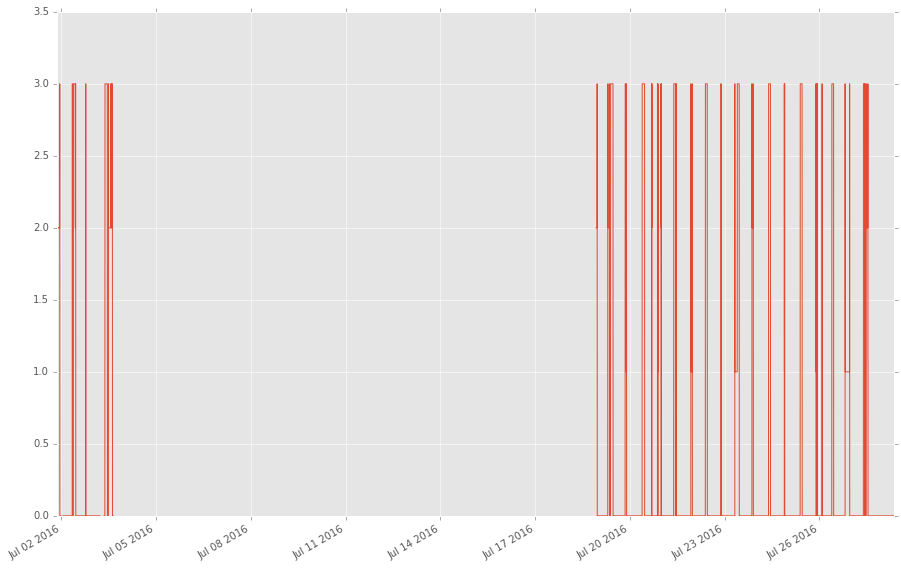

In [41]:
# Now, lets try clustering the data
CLUSTER_LABELS = 4 # how many groups will we create
import numpy as np
from sklearn.cluster import KMeans
# create an array that just has the values, no timestamps
npa = np.array(smoothed_series_writer.result).reshape(-1,1)
capture_nan_indexes.replace_nans(npa, 0.0)
kmeans = KMeans(CLUSTER_LABELS)
kmeans.fit(npa)
# print the raw clustered data
print("kmeans labels: " + str(kmeans.labels_))
from numpy.core.numeric import NaN
labels_with_nans = capture_nan_indexes.new_array_replace_nans(kmeans.labels_, NaN)
labels_against_time = pd.Series(labels_with_nans, index=smoothed_series_writer.index)
labels_against_time.plot(figsize=(15,10))
import pylab
pylab.ylim([0,3.5]) # force the graph top a little higher so that we can see the 3.0 lines

averages = [(2.5711462450592886, 0), (57.447322970639036, 3), (212.80535714285713, 2), (467.7191283292978, 1)]
cluster_mapping = [0, 3, 2, 1]


(0, 3.5)

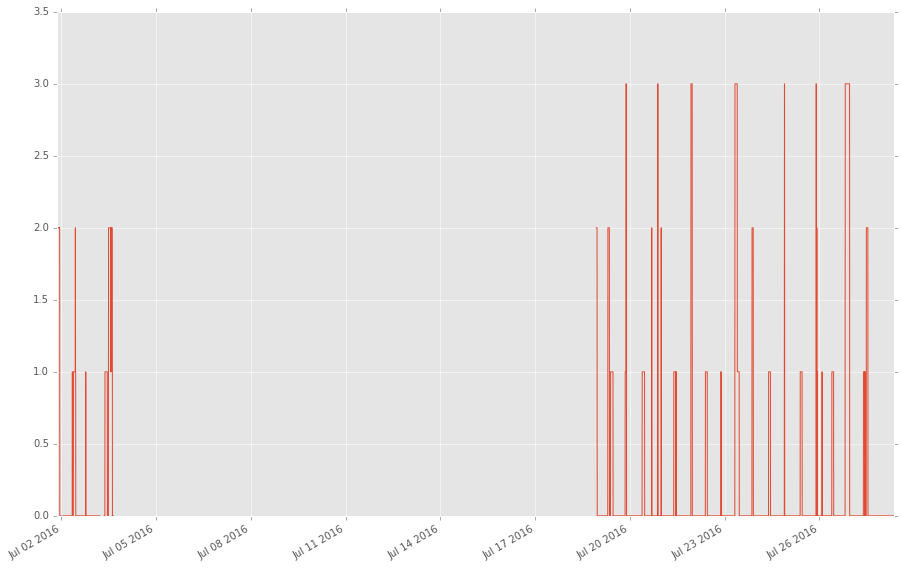

In [42]:
# Unfortunately, the clustered data is creating arbitrary groups. We want the
# integer number to be proportional to the lux value so that the graphs are
# easier to interpret. To do this, we map 0 to the lowest lux level, 3 to
# the highest, etc. In cluster_mapping, the index is the cluster number and
# the value is the one we will graph.
label_totals = [0]*CLUSTER_LABELS
label_counts = [0]*CLUSTER_LABELS
for i in range(len(labels_with_nans)):
    l = labels_with_nans[i]
    if not math.isnan(l):
        lux = smoothed_series_writer.result[i]
        label_totals[l] += lux
        label_counts[l] += 1
averages = [(label_totals[i]/label_counts[i], i) for i in range(CLUSTER_LABELS)]
averages.sort()
print("averages = %s" % averages)
def pivot(array):
    result = [-1]*len(array)
    for i in range(len(array)):
        result[array[i]] = i
    return result
cluster_mapping = pivot([i for (avg, i) in averages])
print("cluster_mapping = %s" % cluster_mapping)
kmeans_lux = [cluster_mapping[l] if not math.isnan(l) else NaN for l in labels_with_nans]
# Now, we can convert it back to a Pandas series by using our original timestamp
# array with the clustered data.
clusters_against_time = pd.Series(kmeans_lux, index=smoothed_series_writer.index)
clusters_against_time.plot(figsize=(15,10))
import pylab
pylab.ylim([0,3.5]) # force the graph top a little higher so that we can see the 3.0 lines

(0, 3.5)

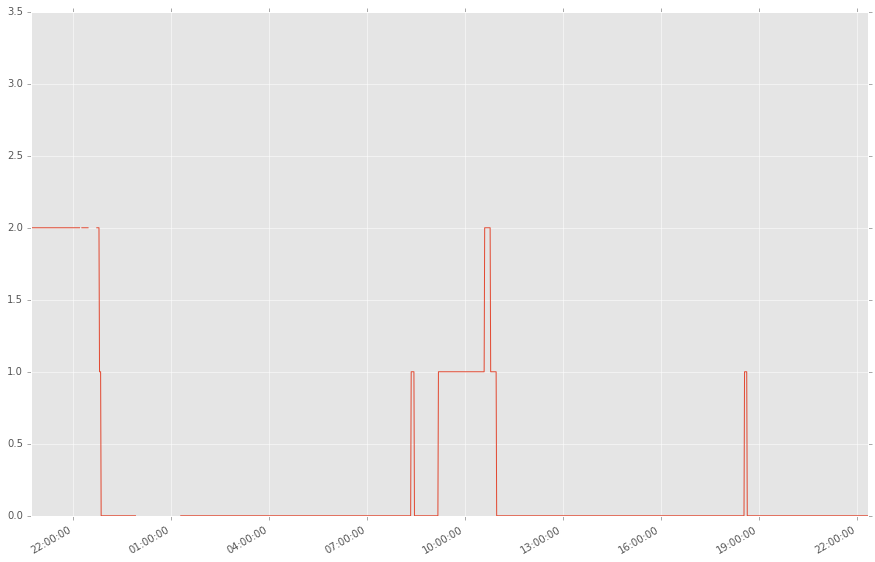

In [43]:
# Lets look at the last day of data to get a closer view
clusters_against_time[:1440].plot(figsize=(15,10))
pylab.ylim([0,3.5]) # force the graph top a little higher so that we can see the 3.0 lines

(0, 1.5)

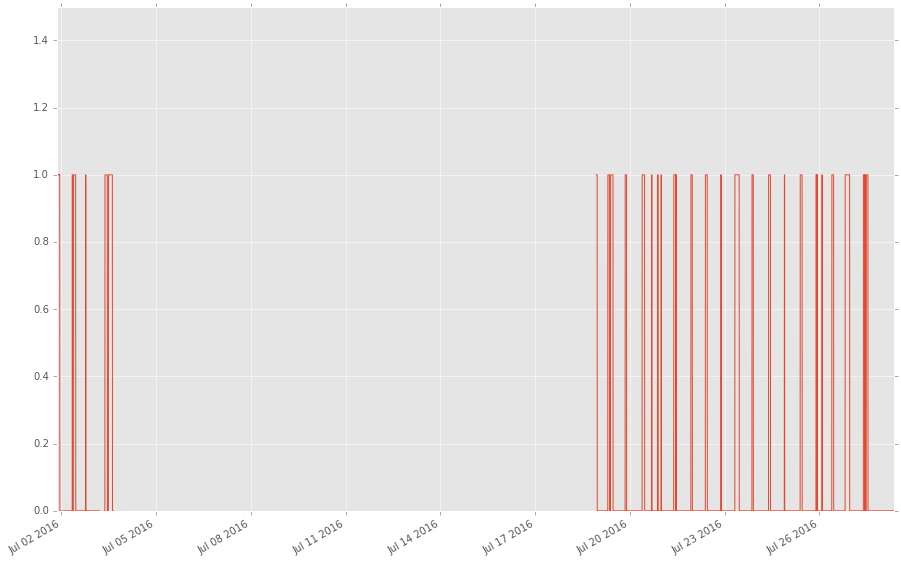

In [44]:
# Now, lets map this to on-off values
# We pick an "on threshold" based on the values we see in the above graph,
# trying to account for ambiant light.
ON_THRESHOLD = 1

def on_off_mapping(v):
    if math.isnan(v):
        return NaN
    elif v>=ON_THRESHOLD:
        return 1
    else:
        return 0

on_off_series = pd.Series([on_off_mapping(l) for l in kmeans_lux], index=smoothed_series_writer.index)
on_off_series.plot(figsize=(15,10))
pylab.ylim([0,1.5])

(0, 1.5)

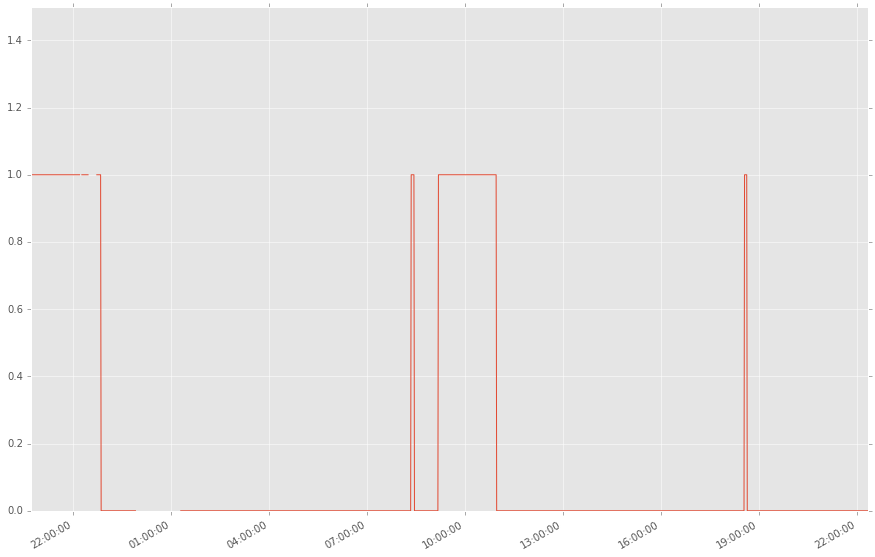

In [45]:
# Graph the last day of the data to get a closer view
on_off_series[:1440].plot(figsize=(15,10))
pylab.ylim([0,1.5])

(0, 4)

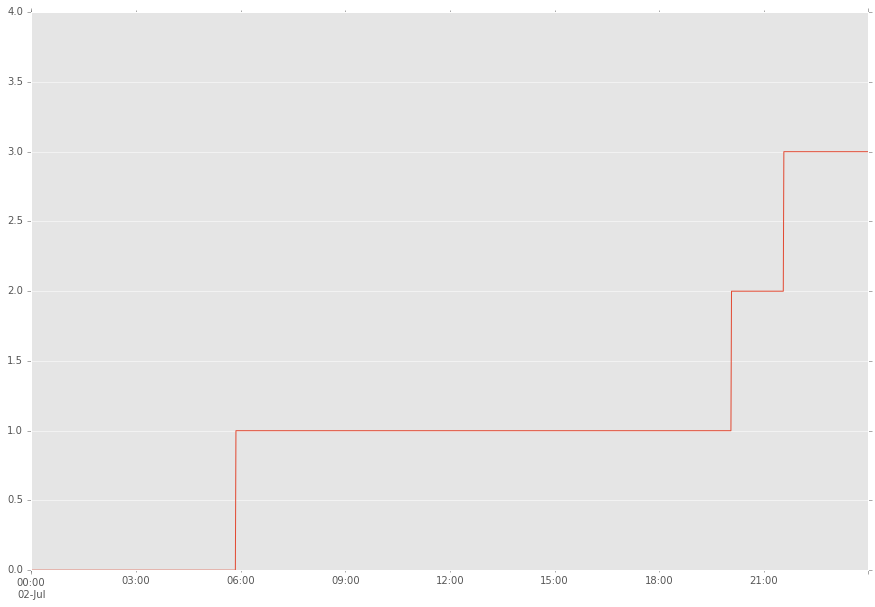

In [46]:
# Import our code that will analyze the data.
import numpy as np
from numpy import float64
import datetime
from lux_analysis import time_of_day_to_zone, dt_to_minutes, NUM_ZONES, get_sunrise_sunset
SUNRISE = 352 # time in minutes since midnight on July 2 (5:52 am)
SUNSET = 1233 # time in minutes since midnight on July 2 (8:33 pm)
(sunrise, sunset) = get_sunrise_sunset(7, 2)
assert SUNRISE==sunrise
assert SUNSET==sunset

# We divide a day into "zones" based on time relative to sunrise/sunset.
# Let's plot our zones for a day
zone_test_index = [datetime.datetime(year=2016, month=7, day=2, hour=h, minute=m)
                   for (h, m) in [(h, m) for h in range(0, 24) for m in range(0, 60)]]
zone_test_data = [time_of_day_to_zone(dt_to_minutes(dt), SUNRISE, SUNSET) for dt in zone_test_index]
zone_test_series = pd.Series(zone_test_data, index=zone_test_index)
zone_test_series.plot(figsize=(15,10))
pylab.ylim([0, NUM_ZONES])

initial state is WAITING
changing to NAN_STATE at 2016-07-01 22:13:39.220200-07:00
changing to WAITING_STATE at 2016-07-01 22:16:48.203777-07:00
changing to NAN_STATE at 2016-07-01 22:29:14.417874-07:00
changing to WAITING_STATE at 2016-07-01 22:44:16.850514-07:00
changing to RECORDING_STATE(0) at 2016-07-01 22:52:16.947294-07:00
changing to NAN_STATE at 2016-07-01 23:56:17.547883-07:00
changing to WAITING_STATE at 2016-07-02 01:18:26.607758-07:00
changing to RECORDING_STATE(1) at 2016-07-02 08:21:31.980507-07:00
ON sequence zone 1, length 6
OFF sequence zone 1, length 44
ON sequence zone 1, length 104
OFF sequence zone 1, length 455
ON sequence zone 1, length 5
changing to NAN_STATE at 2016-07-03 05:20:41.639145-07:00
changing to WAITING_STATE at 2016-07-03 08:31:06.384542-07:00
changing to RECORDING_STATE(1) at 2016-07-03 09:09:06.697680-07:00
ON sequence zone 1, length 111
OFF sequence zone 1, length 50
ON sequence zone 1, length 181
changing to NAN_STATE at 2016-07-03 15:36:11.6326

(array([ 12.,   2.,   2.,   5.,   3.,   5.,   0.,   0.,   0.,   3.]),
 array([   3. ,   22.5,   42. ,   61.5,   81. ,  100.5,  120. ,  139.5,
         159. ,  178.5,  198. ]),
 <a list of 10 Patch objects>)

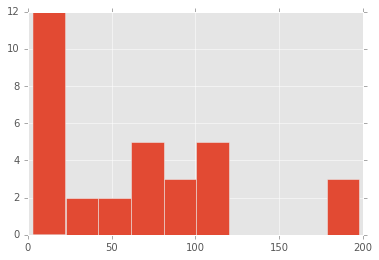

In [47]:
# Build some histograms of the data
from lux_analysis import build_length_histogram_data

length_data = build_length_histogram_data(on_off_series, smoothed_series_writer.index)

# look at the distribution of lengths
from itertools import chain
all_on_lengths = list(chain.from_iterable(length_data.on_lengths))
plt.hist(all_on_lengths)

(array([ 9.,  1.,  0.,  2.,  1.,  0.,  3.,  3.,  6.,  4.]),
 array([   1. ,   69.6,  138.2,  206.8,  275.4,  344. ,  412.6,  481.2,
         549.8,  618.4,  687. ]),
 <a list of 10 Patch objects>)

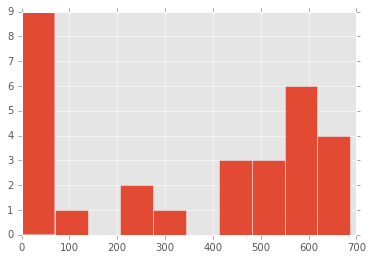

In [48]:
# Show the histogram for all off lengths
all_off_lengths = list(chain.from_iterable(length_data.off_lengths))
plt.hist(all_off_lengths)

zone 0: 4089 samples in 12 subsequences
zone 1: 8574 samples in 13 subsequences
zone 2: 984 samples in 11 subsequences
zone 3: 1640 samples in 14 subsequences
add 372 events for zone 0 on day 7/31
add 815 events for zone 1 on day 7/31
add 104 events for zone 2 on day 7/31
add 149 events for zone 3


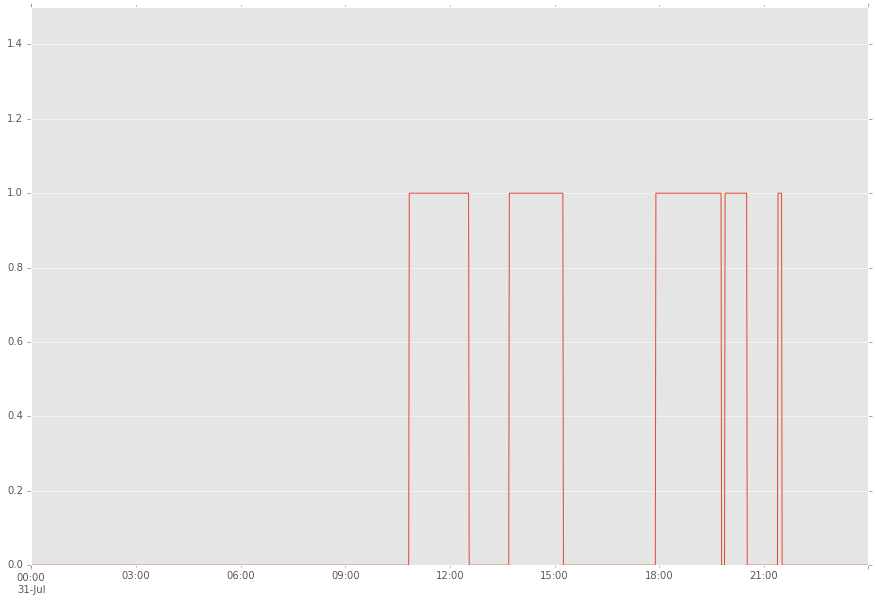

In [49]:
from hmmlearn.hmm import MultinomialHMM as MHMM
from lux_analysis import HmmScanner

# Scan all the samples and produce subsequences of samples for each
# zone, suitable for the hmm fit() method.
scanner = HmmScanner()
scanner.process_samples(on_off_series, smoothed_series_writer.index)

# train hmms by zone
hmm_by_zone = []
for z in range(NUM_ZONES):
    num_states = 5 #max(3, int(1+len(trainer.on_lengths[z])/2))
    #print("%d states for zone %d" % (num_states, z))            
    hmm = MHMM(n_components=num_states)
    data = np.array(scanner.samples_by_zone[z]).reshape(-1,1)
    lengths = np.array(scanner.lengths_by_zone[z])
    print("zone %s: %s samples in %s subsequences" % (z, len(data), len(lengths)))
    hmm.fit(data, lengths)
    hmm_by_zone.append(hmm)

def predict_hmm_by_zone(dt_series):
    predictions = []
    last_zone = None
    last_cnt = None
    for dt in dt_series:
        (sunrise, sunset) = get_sunrise_sunset(dt.month, dt.day)
        zone = time_of_day_to_zone(dt_to_minutes(dt), sunrise, sunset)
        if zone != last_zone:
            if last_cnt is not None:
                print("add %d events for zone %d on day %d/%d" % (last_cnt, last_zone, dt.month, dt.day))
                (samples, states) = hmm_by_zone[last_zone].sample(last_cnt)
                predictions.extend([x[0] for x in samples])
            last_cnt = 1
        else:
            last_cnt += 1
        last_zone = zone
    if last_zone is not None:
        print("add %d events for zone %d" % (last_cnt, last_zone))
        (samples, states) = hmm_by_zone[last_zone].sample(last_cnt)
        predictions.extend([x[0] for x in samples])
    assert len(predictions)==len(dt_series)
    return pd.Series(predictions, index=dt_series)

# generate some perdictions for July 31, 2016
predict_dts_short = [datetime.datetime(year=2016, month=7, day=31, hour=h, minute=m)
                     for (h, m) in [(h, m) for h in range(0, 24) for m in range(0, 60)]]
short_predictions = predict_hmm_by_zone(predict_dts_short)
def plot(predictions):
    predictions.plot(figsize=(15,10))
    pylab.ylim([0, 1.5])
plot(short_predictions)

add 373 events for zone 0 on day 8/1
add 813 events for zone 1 on day 8/1
add 105 events for zone 2 on day 8/1
add 149 events for zone 3 on day 8/2
add 374 events for zone 0 on day 8/2
add 811 events for zone 1 on day 8/2
add 106 events for zone 2 on day 8/2
add 149 events for zone 3 on day 8/3
add 375 events for zone 0 on day 8/3
add 809 events for zone 1 on day 8/3
add 107 events for zone 2 on day 8/3
add 149 events for zone 3 on day 8/4
add 376 events for zone 0 on day 8/4
add 807 events for zone 1 on day 8/4
add 108 events for zone 2 on day 8/4
add 149 events for zone 3 on day 8/5
add 376 events for zone 0 on day 8/5
add 806 events for zone 1 on day 8/5
add 109 events for zone 2 on day 8/5
add 149 events for zone 3 on day 8/6
add 377 events for zone 0 on day 8/6
add 804 events for zone 1 on day 8/6
add 110 events for zone 2 on day 8/6
add 149 events for zone 3 on day 8/7
add 378 events for zone 0 on day 8/7
add 802 events for zone 1 on day 8/7
add 111 events for zone 2 on day 8/7
a

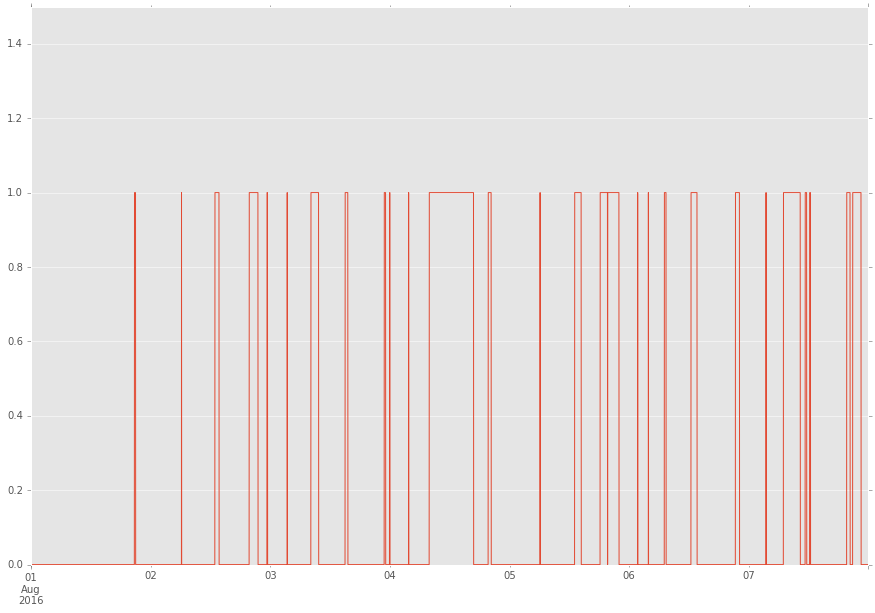

In [50]:
# Now, let's look at some predictions over a week
predict_dts_long = [datetime.datetime(year=2016, month=8, day=d, hour=h, minute=m)
                    for (d, h, m) in [(d, h, m) for d in range(1, 8) for h in range(0, 24)
                                      for m in range(0, 60)]]
long_predictions = predict_hmm_by_zone(predict_dts_long)
plot(long_predictions)

In [51]:
# save the trained HMM to a file
from sklearn.externals import joblib
import os.path
if not os.path.exists('saved_hmms'):
    os.mkdir('saved_hmms')
    print("created saved_hmms direectory")
for zone in range(NUM_ZONES):
    fname = 'saved_hmms/hmm-%s-zone-%d.pkl' % (ROOM, zone)
    joblib.dump(hmm_by_zone[zone], fname)
    print("save hmm to %s" % fname)


save hmm to saved_hmms/hmm-front-room-zone-0.pkl
save hmm to saved_hmms/hmm-front-room-zone-1.pkl
save hmm to saved_hmms/hmm-front-room-zone-2.pkl
save hmm to saved_hmms/hmm-front-room-zone-3.pkl
